Imports. Ensure that the `main_functions.py` file is correclty imported 

In [2]:
import pygsti
import pygsti.modelmembers as mm
import numpy as np
from math import pi
from main_functions import * 

Let's begin with the model definition. We build an explicit model and add custome operations to impose the parametrization in the coloured phase model. To know more about this check the `CustomeOperator.ipynb` tutorial availible at pyGSTi docs. First, we need to define the operator class to add gates to the model

In [3]:
#operator class for the gate

class G(pygsti.modelmembers.operations.DenseOperator):

    def __init__(self, markov_approx, intensity_noise, pulse_duration, phase, representation, gate_index):
        #initialize with no noise
        super(G, self).__init__(np.identity(4,'d'), 'pp', "densitymx_slow") # this is *super*-operator, so "densitymx_slow"
        
        self.markov_approx = markov_approx
        self.intensity_noise = intensity_noise
        self.pulse_duration = pulse_duration
        self.phase = phase
        self.representation = representation
        self.gate_index = gate_index

        init_values = [0, 1e-8] #Small value to avoid divison by zero 
        if not self.markov_approx:
            init_values.extend([0, 0])
        if self.intensity_noise:
            init_values.append(0)

        self.from_vector(init_values)

    def _num_params(self):
        if self.intensity_noise:
            return 3 if self.markov_approx else 5
        else:
            return 2 if self.markov_approx else 4
        
    #return the number of parameters
    @property
    def num_params(self):
        return self._num_params()

    #return the labels of the parameters
    @property
    def parameter_labels(self):
        return [f'G{self.gate_index + 1} param{i+1}' for i in range(self._num_params())]

    #parameter bounds
    @property
    def parameter_bounds(self): #\Gamma_1 > 0 to ensure complete positivity of the matrices

        bounds = [(0, np.inf), (-np.inf, np.inf)]
        bounds.extend([(-np.inf, np.inf)] * (self._num_params() - 2))

        if self._num_params() == 3 or self._num_params() == 5:
            bounds[len(bounds) - 1] = (0, np.inf)

        return bounds
    
    def to_vector(self):

        vector = [self.Gamma_1, self.Delta_1]
        if not self.markov_approx:
            vector.append(self.Gamma_2)
            vector.append(self.Delta_2)
        if self.intensity_noise:
            vector.append(self.DeltaGamma)
            
        return np.array(vector, 'd')
        
    def from_vector(self, v, close = False, dirty_value = True):

        #initialize from parameter vector v
        self.Gamma_1, self.Delta_1 = v[0], v[1]
        self.Gamma_2, self.Delta_2, self.DeltaGamma = 0, 0, 0

        if not self.markov_approx:
            self.Gamma_2, self.Delta_2 = v[2], v[3]
        if self.intensity_noise:
            self.DeltaGamma = v[2 if self.markov_approx else 4]
        
        # ._ptr is a member of DenseOperator and is a numpy array that is 
        # the dense Pauli transfer matrix of this operator
        # Technical note: use [:,:] instead of direct assignment so id of self._ptr doesn't change
        # self._ptr[:,:] = build_gate_ptm(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2, self.DeltaGamma], 'd'),
        #                                 self.pulse_duration, self.markov_approx, phase = self.phase)

        # we build the gate in the phase noise model using the function `build_gate_ptm'
        self._ptr[:,:] = build_gate_ptm(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2, self.DeltaGamma], 'd'),
                                    self.pulse_duration, self.markov_approx, self.intensity_noise, phase = self.phase)

        self.dirty = dirty_value  # mark that parameter vector may have changed

Now we can add custom operations to define our gate set

In [15]:
#For this tutorial we will use the Markovian approximation, which implies \Gamma_2 = \Delta_2 = 0. We also inlcude intenisty noise
markov_approx = True
intensity_noise = True

#Explicit model
mdl = pygsti.models.ExplicitOpModel([0],'pp')

# We add the initial state. It is constrained to be trace preserving
mdl['rho0'] = mm.states.TPState( np.array([ 1/sqrt(2), 0, 0, 1/sqrt(2) ], 'd'), 
                                       evotype = 'densitymx_slow') # density matrix [[1, 0], [0, 0]] in Pauli basis


#We also add a physical measurement operator with two effects.
mdl['Mdefault'] = mm.povms.TPPOVM(
    {'0': [ 1/sqrt(2), 0, 0, 1/sqrt(2) ],   # projector onto [[1, 0], [0, 0]] in Pauli basis
     '1': [ 1/sqrt(2), 0, 0, -1/sqrt(2) ] },# projector onto [[0, 0], [0, 1]] in Pauli basis
    evotype = 'densitymx_slow') # Specify the evolution type when initializing from NumPy arrays.
                                # densitymx is the default


# We add the operations of the chosen gate set to the model

myGates = ['G1', 'G2', 'G3', 'G4', 'G5']
gateSetParams = {'G1': [np.pi, 0], 
                 'G2': [np.pi / 2, 0],
                 'G3': [np.pi / 2, np.pi / 2],
                 'G4': [np.pi / 2, np.pi],
                 'G5': [np.pi / 2, 3 * np.pi / 2]}

for idx, gate in enumerate(myGates):
    mdl[(gate,0)] = G(markov_approx, intensity_noise, *gateSetParams[gate], 'PTM', idx)

# mdl[('Id',0)] = Identity()
#print the model
print(mdl)

rho0 = TPState with dimension 4
 0.71   0   0 0.71


Mdefault = TPPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.71   0   0 0.71

1: ComplementPOVMEffect with dimension 4
 0.71   0   0-0.71



G1:0 = 
G with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0-1.00   0
   0   0   0-1.00


G2:0 = 
G with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0   0-1.00
   0   0 1.00   0


G3:0 = 
G with shape (4, 4)
 1.00   0   0   0
   0   0   0-1.00
   0   0 1.00   0
   0 1.00   0   0


G4:0 = 
G with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0   0 1.00
   0   0-1.00   0


G5:0 = 
G with shape (4, 4)
 1.00   0   0   0
   0   0   0 1.00
   0   0 1.00   0
   0-1.00   0   0






Now, we know from the theoretical model that gates with same pusle duration should be represented with the same set of parameters. We can implement this by  making use of the `collect_parameters()` method, as described in the `ParameterLabels.ipynb` tutorial. However, first we need to rebuild the paramvec, as this is not an automated process when defining the gate set. In the markovian case, the number of free parameters should be 11.

In [16]:
#rebuild the param vector
mdl._rebuild_paramvec()


# we select the collectable parameters according to the model characteristics
collectable_params = {1: 'Gamma_1 pulse = pi/2',
                      2: 'Delta_1 pulse = pi/2'}

if not markov_approx:
    collectable_params[3] = 'Gamma_2 pulse = pi/2'
    collectable_params[4] = 'Delta_2 pulse = pi/2'

if intensity_noise:
    collectable_params[3 if markov_approx else 5] = 'DeltaGamma pulse = pi/2'

# collect the parameters
for keys, vals in collectable_params.items():

    symbolic_param_vec = [((f'G{idx + 1}',0), f'G{idx + 1} param{keys}') for idx in [1, 2, 3, 4]]
    mdl.collect_parameters(symbolic_param_vec, new_param_label = vals)

# check the collected parameters
print(mdl.parameter_labels)
print(mdl.num_params)

[(Label('rho0'), 'VecElement 1') (Label('rho0'), 'VecElement 2')
 (Label('rho0'), 'VecElement 3') (Label('Mdefault'), 'VecElement Re(0)')
 (Label('Mdefault'), 'VecElement Re(1)')
 (Label('Mdefault'), 'VecElement Re(2)')
 (Label('Mdefault'), 'VecElement Re(3)') (Label(('G1', 0)), 'G1 param1')
 (Label(('G1', 0)), 'G1 param2') (Label(('G1', 0)), 'G1 param3')
 'Gamma_1 pulse = pi/2' 'Delta_1 pulse = pi/2' 'DeltaGamma pulse = pi/2']
13


Now that we have defined the theoretical model for our gate set, it is time to simulate data to perform GST. To do so, we create an "experimental_model" which will act as the noisy operations taking place in the device.

In [17]:
#Define some noise parameters for the OU noises in phase and intensity
omega, taus, cs = 1.2566 * 1e3, [5 * 1e-4, 5 * 1e-4], [2 * 1e4, 2 * 1e4]

#params of the noisy operations
gs_params = np.array([[pi, 0],[pi/2, 0],[pi/2, pi/2], [pi/2, pi], [pi/2, 3 * pi/2]])

noise_params = np.array([omega, taus, cs], dtype = 'object')
#The availible faulty inital state parameters
state_params = np.array([1e-1, 1e-1, 0.95])
#The availible faulty measurement operator parameters
measurement_params = np.array([1, 1e-1, 1e-1, 0.95])

#We use the `gate_set_noise_params`class to define the experimental gate set
Gate_set = gate_set_noise_params(noise_params, state_params, measurement_params, 1, markov_approx, intensity_noise, 'PTM', gs_params)

#explicit model definition
experimental_mdl = pygsti.models.ExplicitOpModel([0],'pp')

#model state
experimental_mdl[('rho0',0)] = Gate_set.state()

#model measurement
experimental_mdl[('Mdefault',0)] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': Gate_set.measurement(),  
     '1': [ sqrt(2), 0, 0, 0 ] - Gate_set.measurement()},
    evotype='densitymx_slow')


# Option 1: simulate the date with gates parameterized with the coloured phase model. We would therefore perform tomography with data 
# which we are sure that can fit to the theoretical model. This is used for research purposes to test the performance of the model.

# for idx, gate in enumerate(myGates):
#     experimental_mdl[gate] = Gate_set.gates()[idx]

# Option 2: simulate the data with gates obtained averaging over many noisy instances. This does not make any approximation and it is
# a more realistic scenario.

#Number of stochastic instances
Mnoise = 1e3 #Only for testing purpouses. To have an acceptable accuracy set at least Mnoise = 1e4

for idx, gate in enumerate(myGates):
    experimental_mdl[(gate,0)] = chi2ptm(stochastic_matrices([gs_params[idx, 1]], Mnoise, gs_params[idx, 0], intensity_noise, cs, taus, omega)[0])

We seleect the base circuits and fiducial pairs that we shall employ to perform GST. From the theory we know that single gates serve as an amplificationally complete set when working under this parameterization. Additionally, for each parameter, we select the fiducial pair which stimulates it the most.  

In [34]:
myGates = ['G1', 'G2', 'G3', 'G4', 'G5']

maxLengths = [2**i for i in range(10)] #maxLengths list

# gate set parameters
gs_params = np.array([[pi, 0],[pi/2, 0],[pi/2, pi/2], [pi/2, pi], [pi/2, 3 * pi/2]])

# unitary value parameters
params1 = np.array([0,1e-8,0,0,0,0,1e-8,0,0,0,0,0,1,1,0,0,1])

# circuit parts
prep_fiducials = pygsti.circuits.to_circuits([[('G1',0)], [('G2',0)], [('G3',0)], [('G4',0)], [('G5',0)]])
meas_fiducials = pygsti.circuits.to_circuits([[('G1',0)], [('G2',0)], [('G3',0)], [('G4',0)], [('G5',0)]])
germs = pygsti.circuits.to_circuits([[('G1',0)], [('G2',0)], [('G3',0)], [('G4',0)], [('G5',0)]])
# germs = germsel.find_germs(mdl)

# possible circuits
listOfExperiments = pygsti.circuits.gstcircuits.create_lsgst_circuits(mdl, 
    prep_strs = prep_fiducials, effect_strs = meas_fiducials, germ_list = germs, max_length_list = [1], include_lgst = False)

listOfExperiments = list(listOfExperiments)

# we create a model with the unitary gates
Gate_set1 = gate_set(params1, 1, markov_approx, intensity_noise, 'PTM', gs_params)
experimental_mdl1 = pygsti.models.ExplicitOpModel([0],'pp')
experimental_mdl1['rho0'] = Gate_set1.state()
experimental_mdl1['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': Gate_set1.measurement(),  
     '1': [ sqrt(2), 0, 0, 0 ] - Gate_set1.measurement()},
    evotype='densitymx_slow')
for idx, gate in enumerate(myGates):
    experimental_mdl1[(gate,0)] = (Gate_set1.gates()[idx])# ** maxLengths[len(maxLengths) - 1]

data1 = pygsti.data.simulate_data(experimental_mdl1, listOfExperiments, num_samples = 1,
                                         sample_error = 'none')

epsilon = 1e-7 #small value to perturb the parameters

# parameters to perturb depending on the model properties
if not markov_approx:
    indices = (range(10) if intensity_noise else [0,1,2,3,5,6,7,8,10])
else:
    indices = ([0,1,4,5,6,9,10] if intensity_noise else [0,1,5,6,10])

circuits = []
repetitions = int(np.ceil(mdl.num_params / len(indices)))
for rep in range(repetitions):
    for i in indices:
        if i in range(5):
            gates_for_this_index = [('G1',0)]
        elif i in range(5, 10):
            gates_for_this_index = [('G2',0), ('G3',0), ('G4',0), ('G5',0)]

        params2 = np.array([0,1e-8,0,0,0,0,1e-8,0,0,0,0,0,1,1,0,0,1])

        params2[i] += (epsilon)# if params2[i] < 1 else -epsilon) #perturb the parameter
        Gate_set2 = gate_set(params2, 1, markov_approx, intensity_noise, 'PTM', gs_params) #model with perturbed parameters
        
        experimental_mdl2 = pygsti.models.ExplicitOpModel([0],'pp')
        experimental_mdl2['rho0'] = Gate_set2.state()
        experimental_mdl2['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
            {'0': Gate_set2.measurement(),  
            '1': [ sqrt(2), 0, 0, 0 ] - Gate_set2.measurement()},
            evotype='densitymx_slow')
        for idx, gate in enumerate(myGates):
            experimental_mdl2[(gate,0)] = ( Gate_set2.gates()[idx] )# ** maxLengths[len(maxLengths) - 1]

        data2 = pygsti.data.simulate_data(experimental_mdl2, listOfExperiments, num_samples = 1,
                                                sample_error = 'none')

        #dictionary to store the difference between the unperturbed and perturbed datasets
        data_dif = {}#dict.fromkeys(listOfExperiments)
        for j in listOfExperiments:
            if j[1] in gates_for_this_index:
                data_dif[j] = np.abs( (data1[j][('0',)] - data2[j][('0',)]) )#/ (data1[j][('0',)] + 1e-6)) # We add a small value to avoid division by zero
        sorted_data_dif = np.sort(list(data_dif.values())) #sort the differences
        # print(sorted_data_dif[len(sorted_data_dif) - 1])
        #we store the circuit with the largest difference or 'stimulation'
        circuit = [j for j in data_dif if data_dif[j] == sorted_data_dif[len(sorted_data_dif) - 1]][0]

        listOfExperiments.remove(circuit) #remove the circuit from the potential ones to avoid repetitions
        circuits.append(circuit)

circuits = circuits[:mdl.num_params]

# Populate a fidPairs dictionary with the computed circuits
fidPairs = {}
for i, germ in enumerate(germs):
    if germ not in fidPairs:
        fidPairs[germ] = []
    for j, prep in enumerate(prep_fiducials):
        for k, meas in enumerate(meas_fiducials):
            circuit = prep + germ + meas
            if circuit in circuits:
                fidPairs[germ].append((j, k))

print(fidPairs)

#list of experiments for long sequence GST
listOfExperiments = pygsti.circuits.gstcircuits.create_lsgst_circuits(
                myGates, prep_fiducials, meas_fiducials, germs, maxLengths, fidPairs, include_lgst = False) #should include fidPairs

{Circuit(G1:0@(0)): [(0, 0), (0, 1), (0, 3), (1, 3), (2, 4), (3, 1)], Circuit(G2:0@(0)): [(0, 1), (0, 2), (1, 0), (1, 1), (2, 4), (4, 2)], Circuit(G3:0@(0)): [(2, 2)], Circuit(G4:0@(0)): [], Circuit(G5:0@(0)): []}


Alternatively, we can do something similar with pyGSTi builtin functions

In [19]:
# import pygsti.algorithms.fiducialselection as fidsel
# import pygsti.algorithms.germselection as germsel

# # operations for SPAM and germs
# prep_fiducials = pygsti.circuits.to_circuits([[('G1',0)], [('G2',0)], [('G3',0)], [('G4',0)], [('G5',0)]])
# meas_fiducials = pygsti.circuits.to_circuits([[('G1',0)], [('G2',0)], [('G3',0)], [('G4',0)], [('G5',0)]])
# germs = pygsti.circuits.to_circuits([[('G1',0)], [('G2',0)], [('G3',0)], [('G4',0)], [('G5',0)]])

# prep_fiducials, meas_fiducials = fidsel.find_fiducials(mdl)
# germs = germsel.find_germs(mdl) #, candidate_germ_counts = {1: 'all upto'}) # if we constraint germs to a given length
# fidPairs = pygsti.alg.find_sufficient_fiducial_pairs_per_germ(mdl, prep_fiducials, meas_fiducials, germs = germs,
#                                                              search_mode = 'sequential', verbosity = 1, retry_for_smaller = True)

# # fidPairs = pygsti.alg.find_sufficient_fiducial_pairs_per_germ_global(mdl, prep_fiducials, meas_fiducials, germs = germs,
# #                                                              verbosity = 1)

# print(fidPairs)

# # list of max lengths for long-sequence circutis
# maxLengths = [2**i for i in range(7)]

# # the list of experiments to execute
# listOfExperiments = pygsti.circuits.gstcircuits.create_lsgst_circuits(
#     myGates, prep_fiducials, meas_fiducials, germs, maxLengths, include_lgst = False) #should include fidPairs when needed

Data simulation. We might have some ComplexWarning because the average stochastic matrices have some remaining negligible complex elements

In [20]:
#shots to obtain experimental frequencies for each circuit
shots = 1e7

#simulate the data
data = pygsti.data.simulate_data(experimental_mdl, listOfExperiments, num_samples = shots,
                                         sample_error = 'binomial')

/Users/pablovinasmartinez/opt/anaconda3/envs/coloured_GST/lib/python3.12/site-packages/pygsti/models/model.py:974: ComplexWarning: Casting complex values to real discards the imaginary part
  w[obj.gpindices] = obj.to_vector()
/Users/pablovinasmartinez/opt/anaconda3/envs/coloured_GST/lib/python3.12/site-packages/pygsti/forwardsims/matrixforwardsim.py:746: ComplexWarning: Casting complex values to real discards the imaginary part
  prodCache[iDest] = gate / nG


We fit using long sequence GTS. We do not need to perfrom gauge optimisation because there is not gauge freedom with our parameterization.

In [21]:
#some custom GST options
my_adv_options = {'tolerance': 1e-4, 'starting_point': 'target', 'max_iterations': 1000}

#run lsGST
results = pygsti.run_long_sequence_gst(data, mdl, prep_fiducials, meas_fiducials,
                                           germs, maxLengths, gauge_opt_params = False, advanced_options = my_adv_options, verbosity = 1)
                                           

#We define a model with the results
mdl_estimate = results.estimates['GateSetTomography'].models['final iteration estimate']

--- Circuit Creation ---
--- Iterative GST: [##################################################] 100.0%  130 circuits ---


Let's compare the resutls

In [22]:
G_estimate, G_experimental = mdl_estimate[('G1',0)].to_dense(), experimental_mdl[('G1',0)].to_dense()

print(G_estimate)
print(G_experimental)

print(pygsti.tools.tracedist(mdl_estimate[('G1',0)].to_dense(), experimental_mdl[('G1',0)].to_dense()))

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.99996429e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.99994256e-01  3.13239629e-05]
 [ 0.00000000e+00  0.00000000e+00 -3.13239629e-05 -9.99994256e-01]]
[[ 1.00000000e+00+0.j -6.77626358e-21+0.j -2.33103467e-18+0.j
   0.00000000e+00+0.j]
 [-1.30485426e-21+0.j  9.99996410e-01+0.j  5.65039730e-05+0.j
  -5.27725092e-05+0.j]
 [ 2.32886415e-18+0.j  5.66588490e-05+0.j -9.99994623e-01+0.j
   3.07743001e-05+0.j]
 [ 0.00000000e+00+0.j -5.30364764e-05+0.j -3.04564470e-05+0.j
  -9.99993628e-01+0.j]]
7.762764077246817e-05


To see if GST recovers the right parameters, let us use data simulated with the parameterized model (Option 1 in the experimental model cell). To make sure everything works, we will use a **very noisy** model.

In [23]:
#some custom GST options
my_adv_options = {'tolerance': 1e-4, 'starting_point': 'target', 'max_iterations': 1000}

#Define some noise parameters for the OU noises
omega, taus, cs = 1.2566 * 1e3, [5 * 1e-4, 5 * 1e-4], [2 * 1e8, 2 * 1e8]

#params of the noisy operations
gs_params = np.array([[pi, 0],[pi/2, 0],[pi/2, pi/2], [pi/2, pi], [pi/2, 3 * pi/2]])

noise_params = np.array([omega, taus, cs], dtype = 'object')
#The availible faulty inital state parameters
state_params = np.array([1e-1, 1e-1, 0.95])
#The availible faulty measurement operator parameters
measurement_params = np.array([1, 1e-1, 1e-1, 0.95])

#We use the `gate_set_noise_params`class to define the experimental gate set
Gate_set = gate_set_noise_params(noise_params, state_params, measurement_params, 1, markov_approx, intensity_noise, 'PTM', gs_params)

#explicit model definition
experimental_mdl = pygsti.models.ExplicitOpModel([0],'pp')

#model state
experimental_mdl['rho0'] = Gate_set.state()

#model measurement
experimental_mdl['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': Gate_set.measurement(),  
     '1': [ sqrt(2), 0, 0, 0 ] - Gate_set.measurement()},
    evotype='densitymx_slow')

for idx, gate in enumerate(myGates):
    experimental_mdl[(gate,0)] = Gate_set.gates()[idx]

#shots to obtain experimental frequencies for each circuit
shots = 1e4

#simulate the data
data = pygsti.data.simulate_data(experimental_mdl, listOfExperiments, num_samples = shots,
                                         sample_error = 'binomial')


#run lsGST
results = pygsti.run_long_sequence_gst(data, mdl, prep_fiducials, meas_fiducials,
                                           germs, maxLengths, gauge_opt_params = False, advanced_options = my_adv_options, verbosity = 1)     

#We define a model with the results
mdl_estimate = results.estimates['GateSetTomography'].models['final iteration estimate']     
# mdl_estimate = pygsti.algorithms.gaugeopt_to_target(mdl_estimate, experimental_mdl, verbosity = 1) # we can test gauge opt                   

--- Circuit Creation ---
--- Iterative GST: [##################################################] 100.0%  130 circuits ---


We compare the parameters. We get some shot noise, but recover the correct set.

In [24]:
G_estimate, G_experimental = mdl_estimate[('G1',0)].to_dense(), experimental_mdl[('G1',0)].to_dense()
vec_estimate, vec_experimental = mdl_estimate[('G1',0)].to_vector(), quantum_channel(pi, omega, taus, cs, p = 1, markovian_approx = markov_approx
                                                                                 , intensity_noise = intensity_noise,  representation = 'PTM', phase = 0)[1:]

print(vec_estimate)
print(vec_experimental)

[0.04057237 0.01848589 0.10049418]
(0.04089667396096544, 0.020026551703634543, 0.0, 0.0, 0.10017211051410037)


We finally also compare the gates

In [25]:
print(G_estimate)
print(G_experimental)
print(np.linalg.eig(ptm2chi(G_estimate))[0]) # we check that the eigenvalues of the chi matrix are positive (complete positivity)

print(pygsti.tools.tracedist(mdl_estimate[('G2',0)].to_dense(), experimental_mdl[('G2',0)].to_dense()))

[[ 1.          0.          0.          0.        ]
 [ 0.          0.96023967  0.          0.        ]
 [ 0.          0.         -0.93185692  0.00861335]
 [ 0.          0.         -0.00861335 -0.93185692]]
[[ 1.          0.          0.          0.        ]
 [ 0.          0.95992831  0.          0.        ]
 [ 0.          0.         -0.93184897  0.00933117]
 [ 0.          0.         -0.00933117 -0.93184897]]
[0.02411155+0.j 0.95600828+0.j 0.00994008-0.j 0.00994008+0.j]
0.0009392299030639617


Let us now check that the IC set is attained when the number of independent circuits used for GST approximates to the number of parameters to determine. To avoid local minima issues when depth = 1, we are doing it setting intensity_noise = False. It is important to **re-run** previous cells accordingly to replicate the results. The number of parameters for this case is $N_{\rm param} = 11$

In [13]:
iterations = 10
num_circs = range(2,20)
shots = 1e9
maxLengths = [1]
results_array  = np.empty([len(num_circs), iterations])

#list of circs with maxLenght = 1
listOfExperiments = pygsti.circuits.gstcircuits.create_lsgst_circuits(
    myGates, prep_fiducials, meas_fiducials, germs, maxLengths, fidPairs, include_lgst = False) #should include fidPairs when needed

# extra circuits to add to the list
the_extra_circs = []
for germ in germs:
    for prep in prep_fiducials:
        for meas in meas_fiducials:
            circuit = prep + germ + meas
            if circuit not in listOfExperiments:
                the_extra_circs.append(circuit)

listOfExperiments = list(listOfExperiments) + the_extra_circs

for iter in range(iterations):
    for index, circs in enumerate(num_circs):

        # this is to rewrite the circuit_list in the appropriate fidPairs format
        fidPairs = {}
        for i, germ in enumerate(germs):
            if germ not in fidPairs:
                fidPairs[germ] = []
            for j, prep in enumerate(prep_fiducials):
                for k, meas in enumerate(meas_fiducials):
                    circuit = prep + germ + meas
                    if circuit in listOfExperiments[0:circs]:
                        fidPairs[germ].append((j, k))

        experiments = pygsti.circuits.gstcircuits.create_lsgst_circuits(
                 myGates, prep_fiducials, meas_fiducials, germs, maxLengths, fidPairs, include_lgst = False) #should include fidPairs

        #simulate the data
        data = pygsti.data.simulate_data(experimental_mdl, experiments, num_samples = shots,
                                                sample_error = 'binomial')


        #run lsGST
        results = pygsti.run_long_sequence_gst(data, mdl, prep_fiducials, meas_fiducials,
                                                germs, maxLengths, gauge_opt_params = False, advanced_options = my_adv_options, verbosity = 0)     

        #We define a model with the results
        mdl_estimate = results.estimates['GateSetTomography'].models['final iteration estimate']   
        
        # experimental_mdl = pygsti.algorithms.gaugeopt_to_target(experimental_mdl1, experimental_mdl) # we can test gauge opt

        results_array [index, iter] = 0
        for idx, gate in enumerate(myGates):
            results_array [index, iter] += pygsti.tools.tracedist(mdl_estimate[(gate,0)].to_dense(), experimental_mdl[(gate,0)].to_dense()) / (len(myGates) + 2)
        vec1, vec2 = mdl_estimate['rho0'].to_vector(), mdl_estimate['Mdefault'].to_vector()
        results_array [index, iter] += np.sqrt((1e-1/sqrt(2) - vec1[0]) ** 2 + (1e-1/sqrt(2) - vec1[1]) ** 2 + (0.95/sqrt(2) - vec1[2]) ** 2) / (len(myGates) + 2)
        results_array [index, iter] += np.sqrt((1e-1/sqrt(2) - vec2[1]) ** 2 + (1e-1/sqrt(2) - vec2[2]) ** 2 + (0.95/sqrt(2) - vec2[3]) ** 2) / (len(myGates) + 2)                          

/Users/pablovinasmartinez/opt/anaconda3/envs/coloured_GST/lib/python3.12/site-packages/pygsti/layouts/evaltree.py:183: UserWarning: Created an evaluation tree that is inefficient: tree-size > 3 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).
  _warnings.warn(("Created an evaluation tree that is inefficient: tree-size > %d * #circuits !\n"


Check that we get accurate results with, at least, $N_{\rm circs} = N_{\rm params}=11$

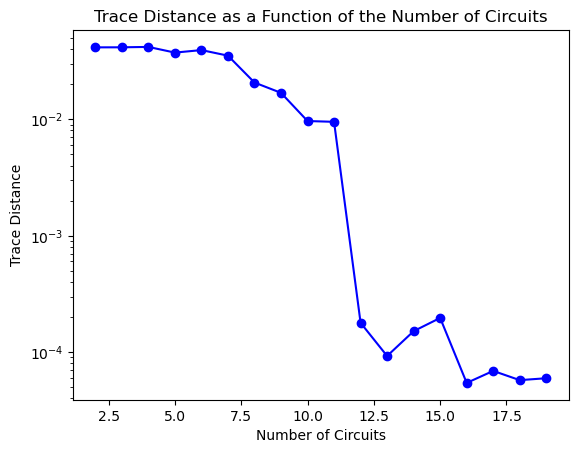

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#we average ethe results over the iterations
trace_distances = results_array.mean(axis = 1)

# Creating the log-log plot
plt.semilogy(np.array(num_circs) * len(maxLengths), trace_distances, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Number of Circuits')
plt.ylabel('Trace Distance')
plt.title('Trace Distance as a Function of the Number of Circuits')

# Display the plot
plt.show()

Lastly, we will progressively increase the number of shots to reproduce Fig. 3 of the paper. We select an interval of shots ranging in $N_{\rm b,s}\in [10^2-10^7]$. We repeat the experiment 10 times to limit the variance. (Run option 1 for Fig.3, and option 2 for Fig. 4)

In [64]:
my_adv_options = {'tolerance': 1e-4, 'starting_point': 'target', 'max_iterations': 1000}

##This will take some minutes
omega, taus, cs = 1.2566 * 1e3, [5 * 1e-4, 5 * 1e-4], [2 * 1e4, 2 * 1e5]

#params of the noisy operations
gs_params = np.array([[pi, 0],[pi/2, 0],[pi/2, pi/2], [pi/2, pi], [pi/2, 3 * pi/2]])

noise_params = np.array([omega, taus, cs], dtype = 'object')


#We use the `gate_set_noise_params`class to define the experimental gate set
Gate_set = gate_set_noise_params(noise_params, state_params, measurement_params, 1, markov_approx, intensity_noise, 'PTM', gs_params)

#explicit model definition
experimental_mdl = pygsti.models.ExplicitOpModel([0],'pp')

#model state
experimental_mdl['rho0'] = Gate_set.state()

#model measurement
experimental_mdl['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': Gate_set.measurement(),  
     '1': [ sqrt(2), 0, 0, 0 ] - Gate_set.measurement()},
    evotype='densitymx_slow')

for idx, gate in enumerate(myGates):
    experimental_mdl[(gate,0)] = Gate_set.gates()[idx]



######### FOR OPT. 1 #########
# shots_array = np.logspace(2,7,10)
##############################

######### FOR OPT. 2 #########
shots_array = [1e3]
##############################

#To obtain accurate results we should set iterations = 100
iterations = 10

results_array = np.empty([len(shots_array), iterations])

results_vs_p = np.empty([len(maxLengths), iterations])

for idx, shots in enumerate(shots_array):

    for iter in range(iterations): 

        print(iter)
    
        #simulate the data
        data = pygsti.data.simulate_data(experimental_mdl, listOfExperiments, num_samples = shots,
                                                sample_error = 'binomial')

        #run lsGST
        results = pygsti.run_long_sequence_gst(data, mdl, prep_fiducials, meas_fiducials,
                                                germs, maxLengths, gauge_opt_params = False, advanced_options = my_adv_options, verbosity = 0)   


        #We define a model with the results and get the trace distance between the experimental and estimated models

        ######### FOR OPT. 1 #########

        # mdl_estimate = results.estimates['GateSetTomography'].models['final iteration estimate']   

        # results_array[idx, iter] = 0
        # for gate in myGates:
        #     results_array[idx, iter] += pygsti.tools.tracedist(mdl_estimate[(gate,0)].to_dense(), experimental_mdl[(gate,0)].to_dense()) / (len(myGates) + 2)
            
        # vec1, vec2 = mdl_estimate['rho0'].to_vector(), mdl_estimate['Mdefault'].to_vector()
        # results_array[idx, iter] += np.sqrt((1e-1/sqrt(2) - vec1[0]) ** 2 + (1e-1/sqrt(2) - vec1[1]) ** 2 + (0.95/sqrt(2) - vec1[2]) ** 2) / (len(myGates) + 2)
        # results_array[idx, iter] += np.sqrt((1e-1/sqrt(2) - vec2[1]) ** 2 + (1e-1/sqrt(2) - vec2[2]) ** 2 + (0.95/sqrt(2) - vec2[3]) ** 2) / (len(myGates) + 2)  

        ##############################  

        ######### FOR OPT. 2 #########

        get_results = results.estimates['GateSetTomography']

        for i in range(len(get_results.models) - 4):
        
            mdl_estimate = results.estimates['GateSetTomography'].models[f'iteration {i} estimate'] 

            # mdl_estimate = pygsti.algorithms.gaugeopt_to_target(mdl_estimate, experimental_mdl) # we can test gauge opt

            results_vs_p[i, iter] = 0
            for idx, gate in enumerate(myGates):
                # print(gate, pygsti.tools.tracedist(mdl_estimate[(gate,0)].to_dense(), experimental_mdl[(gate,0)].to_dense()) / (len(myGates)))
                results_vs_p[i, iter] += pygsti.tools.tracedist(mdl_estimate[(gate,0)].to_dense(), experimental_mdl[(gate,0)].to_dense()) / (len(myGates))

                # we avoid computing trace distances for SPAM elements becouse those parameters are not amplified in lsGST.

        ##############################                     

0
1
2
3
4
5
6
7
8
9


slope =  -0.5328357222248331


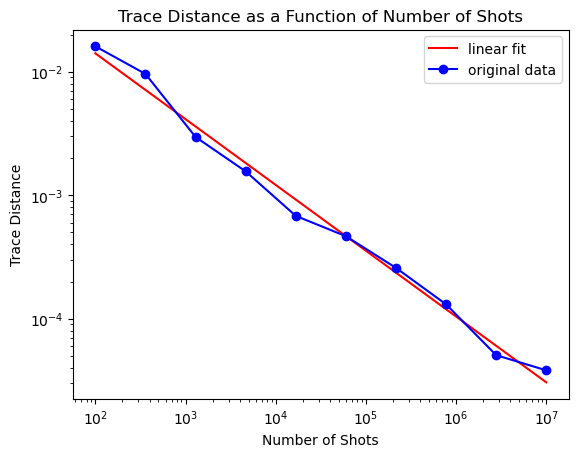

In [62]:
import matplotlib.pyplot as plt
import numpy as np

#we average ethe results over the iterations
trace_distances = results_array.mean(axis = 1)

#linear fit
log_x = np.log10(shots_array)
log_y = np.log10(trace_distances)
coefficients = np.polyfit(log_x, log_y, 1)  # 1 means linear
print('slope = ', coefficients[0])
polynomial = np.poly1d(coefficients)
fit_x = np.linspace(min(log_x), max(log_x), 100)
fit_y = np.power(10, polynomial(fit_x))
fit_x_original_scale = np.power(10, fit_x)

# Creating the log-log plot
plt.loglog(fit_x_original_scale, fit_y, 'r-', label = 'linear fit')
plt.loglog(shots_array, trace_distances, marker='o', linestyle='-', color='b', label = 'original data')

# Adding labels and title
plt.xlabel('Number of Shots')
plt.ylabel('Trace Distance')
plt.title('Trace Distance as a Function of Number of Shots')
plt.legend()

# Display the plot
plt.show()

If we repeat this experiment many times, we should obtain a slope close to -0.5. This can be already appreciated in the graph above for just 10 iteration. If we plot the results as a function of depth, the slope should be near -1 (Fig. 4).

slope =  -1.0983870418453507


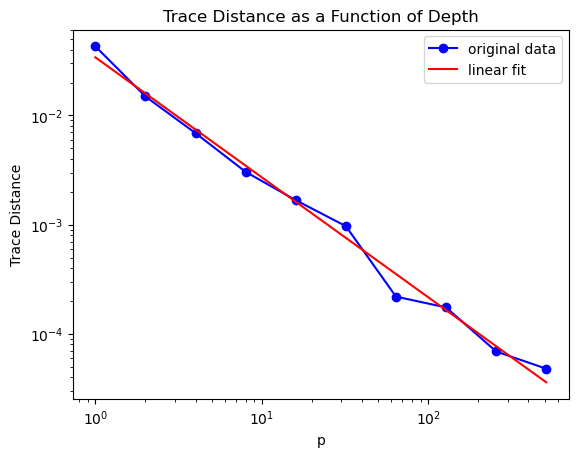

In [65]:
import matplotlib.pyplot as plt
import numpy as np

#we average ethe results over the iterations
trace_distances = results_vs_p.mean(axis = 1)
maxLengths = [2**i for i in range(10)]
# trace_distances = trace_distances[1:len(maxLengths)]
# maxLengths = maxLengths[1:len(maxLengths)]

# Creating the log-log plot
plt.loglog(maxLengths, trace_distances, marker='o', linestyle='-', color='b', label = 'original data')

#linear fit
log_x = np.log10(maxLengths)
log_y = np.log10(trace_distances)
coefficients = np.polyfit(log_x, log_y, 1)  # 1 means linear
print('slope = ', coefficients[0])
polynomial = np.poly1d(coefficients)
fit_x = np.linspace(min(log_x), max(log_x), 100)
fit_y = np.power(10, polynomial(fit_x))
fit_x_original_scale = np.power(10, fit_x)

plt.loglog(fit_x_original_scale, fit_y, 'r-', label='linear fit')

# Adding labels and title
plt.xlabel('p')
plt.ylabel('Trace Distance')
plt.title('Trace Distance as a Function of Depth')
plt.legend()

# Display the plot
plt.show()